# Highlight subpocket fragments in a ligand

This notebook is an exploratory notebook and exists only thanks to [Greg's blog post](https://rdkit.blogspot.com/2020/10/molecule-highlighting-and-r-group.tml) on how to highlight multiple parts of a ligand with muliple colors using the RDKit.

__Needs `rdkit` version 2020.09.1!__

Highlight here subpocket fragments at the example of 
- PDB structure `3W2S` with ligand `W2R` (KLIFS ID [778](https://klifs.net/details.php?structure_id=778))
- [or] PDB structure `IG5S` with ligand `I17` (KLIFS ID [3888](https://klifs.net/details.php?structure_id=3888))

This is a first step towards offering this functionality as part of the `kinfraglib` library in the future.

In [1]:
KLIFS_STRUCTURE_ID = 778  # 3888
EXAMPLE_LIGAND_ID = "W2R"  # "I17"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!conda install -y rdkit=2020.09.1

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
[y/N]: 

In [ ]:
from collections import defaultdict
import copy
from pathlib import Path

import rdkit
from rdkit import Chem, Geometry
from rdkit.Chem import Draw, PandasTools, rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
import pandas as pd
import matplotlib
from IPython.display import SVG,Image
from ipywidgets import interact

from opencadd.databases.klifs import setup_remote
from kinfraglib import utils

IPythonConsole.molSize=(450,350)
rdDepictor.SetPreferCoordGen(True)
PandasTools.RenderImagesInAllDataFrames(images=True)

if rdkit.__version__ != "2020.09.1":
    raise Exception(
        f"This notebooks needs rdkit version 2020.09.1. "
        f"You have {rdkit.__version__}."
        f"Please run !conda install -y rdkit=2020.09.1."
    )

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/pkgutil.py", line 415, in get_importer
    importer = sys.path_importer_cache[path_item]
KeyError: ''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nona/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-dd47b804358a>", line 14, in <module>
    from opencadd.databases.klifs import setup_remote
  File "/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/site-packages/opencadd/databases/klifs/__init__.py", line 5, in <module>
    from .api import setup_local, setup_remote
  File "/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/site-packages/opencadd/databases/klifs/api.py", line 11, in <module>
    from .session import Session
  File "/home/nona/anaconda3/envs/kinfraglib/lib/python3.8/site-packages/open

## Load fragments

... from the KinFragLib fragment library. Select fragment data for our example ligand-kinase complex.

In [5]:
# Path to library folder
HERE = Path(_dh[-1])
PATH_TO_LIB = HERE / '../../data/fragment_library'

In [6]:
# Use utils function to read fragment library
fragment_library = utils.read_fragment_library(PATH_TO_LIB)
fragment_library_concat = pd.concat(fragment_library)

In [7]:
# Select fragments for the example ligand
fragments_df = fragment_library_concat[fragment_library_concat["ligand_pdb"] == EXAMPLE_LIGAND_ID]
fragments = {}
for index, fragment in fragments_df.iterrows():
    fragments[index[0]] = Chem.MolFromSmiles(fragment["smiles"])
fragments

{'AP': <rdkit.Chem.rdchem.Mol at 0x7f397b1afa30>,
 'FP': <rdkit.Chem.rdchem.Mol at 0x7f397aaa2c60>,
 'GA': <rdkit.Chem.rdchem.Mol at 0x7f397aaa2f80>,
 'B1': <rdkit.Chem.rdchem.Mol at 0x7f397aaa2f30>,
 'B2': <rdkit.Chem.rdchem.Mol at 0x7f397aac1120>}

## Set RGB values for subpocket colors

In [8]:
SUBPOCKET_COLORS = {
    "AP": "xkcd:purplish", #"purple",
    "FP": "xkcd:flat green", #"forestgreen",
    "SE": "paleturquoise", #"c",
    "GA": "orange", #"tab:orange",
    "B1": "tab:blue",
    "B2": "blueviolet", #"darkslateblue",
    "X": "grey",
}

In [9]:
colors = {}
for name, color in SUBPOCKET_COLORS.items():
    colors[name] = matplotlib.colors.to_rgb(color)
colors

{'AP': (0.5803921568627451, 0.33725490196078434, 0.5490196078431373),
 'FP': (0.4117647058823529, 0.615686274509804, 0.2980392156862745),
 'SE': (0.6862745098039216, 0.9333333333333333, 0.9333333333333333),
 'GA': (1.0, 0.6470588235294118, 0.0),
 'B1': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'B2': (0.5411764705882353, 0.16862745098039217, 0.8862745098039215),
 'X': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255)}

## Load full example molecule

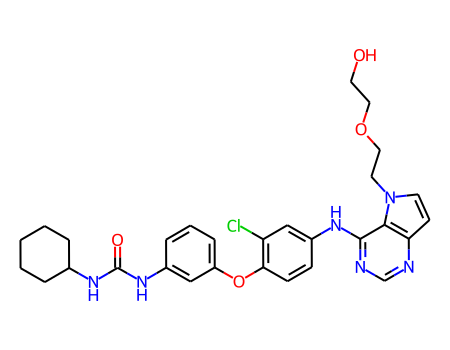

In [10]:
remote = setup_remote()
mol = remote.coordinates.to_rdkit(KLIFS_STRUCTURE_ID, "ligand")
mol

## Orient ligand with respect to kinase subpockets (manual step)

1. Draw atom indices in image, in order to decide which atoms to pick for molecule re-orientation.

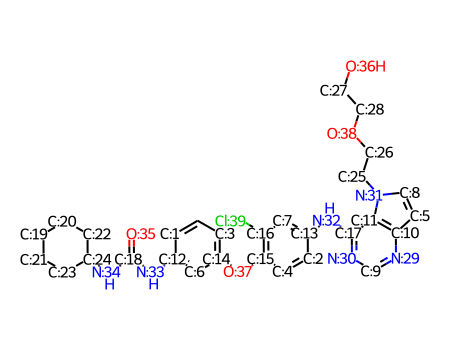

In [11]:
# Add atom indices in image
def addAtomIndices(mol):
    for i, a in enumerate(mol.GetAtoms()):
        a.SetAtomMapNum(i)
        
# Make copy of mol object (to be used to check out atom indices)
mol_copy = copy.deepcopy(mol)
addAtomIndices(mol_copy)
mol_copy

2. Orient molecule in the desired orientation (this step is _manual_, think about automatization in the future!).

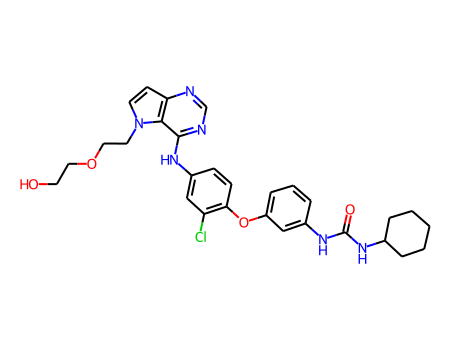

In [12]:
rdDepictor.Compute2DCoords(
    mol, 
    coordMap={
        27: Geometry.Point2D(0,0), 
        36: Geometry.Point2D(-1.5,0)
    }
)
mol
# Atom indices 5 and 10 for structure KLIFS ID 3888

## Per fragment: Get atoms and bonds to be highlighted

Uses a lot of code from [Greg's blog post](https://rdkit.blogspot.com/2020/10/molecule-highlighting-and-r-group.tml).

In [13]:
highlight_atoms = defaultdict(list)
highlight_bonds = defaultdict(list)
highlight_radius = {}
highligh_linewidth = {}
rings = []

mol_rings = mol.GetRingInfo().AtomRings()

for subpocket_name, fragment in fragments.items():
    
    # Get fragment indices (as set in the original molecule)
    fragment_atom_idx = mol.GetSubstructMatch(fragment)
    # Get subpocket color
    color = colors[subpocket_name]
    
    # Highlight information for rings
    for ring in mol_rings:
        # Add only those rings that belong to current fragment
        if len(set(ring) - set(fragment_atom_idx)) == 0:
            rings.append((ring, color))
    
    for atom_idx in fragment_atom_idx:
        
        # Highlight information for atoms
        highlight_atoms[atom_idx].append(color)
        highlight_radius[atom_idx] = 0.4
    
        # Highlight information for bonds
        atom = mol.GetAtomWithIdx(atom_idx)
        bonds = atom.GetBonds()
        for bond in bonds:
            atom_idx_begin = bond.GetBeginAtom().GetIdx()
            atom_idx_end = bond.GetEndAtom().GetIdx()
            if (atom_idx_begin in fragment_atom_idx) and (atom_idx_end in fragment_atom_idx):
                bond_idx = bond.GetIdx()
                highlight_bonds[bond_idx].append(color)
                highligh_linewidth[bond_idx] = 2

## Draw ligand with highlighted subpocket fragments

Uses the `rdMolDraw2D` functionality [`DrawMoleculeWithHighlights()`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html). 
Code is taken from [Greg's blog post](https://rdkit.blogspot.com/2020/10/molecule-highlighting-and-r-group.tml).

In [14]:
legend = ""

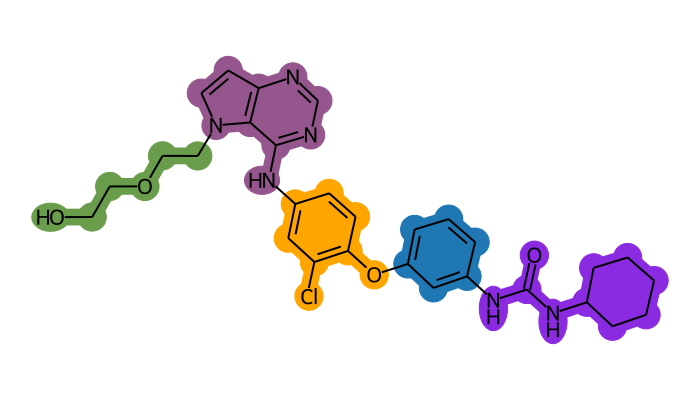

In [15]:
width = 700
height = 400
d2d = rdMolDraw2D.MolDraw2DCairo(width, height)
dos = d2d.drawOptions()
dos.useBWAtomPalette()

# First draw circles to highlight full rings
d2d.DrawMoleculeWithHighlights(
    mol,
    legend,
    dict(highlight_atoms),
    dict(highlight_bonds),
    highlight_radius, 
    highligh_linewidth
)
d2d.ClearDrawing()
conf = mol.GetConformer()
for (ring, color) in rings:
    positions = []
    for atom_idx in ring:
        position = Geometry.Point2D(conf.GetAtomPosition(atom_idx))
        positions.append(position)
    d2d.SetFillPolys(True)
    d2d.SetColour(color)
    d2d.DrawPolygon(positions)
dos.clearBackground = False

# Now draw on top (again) the molecule with highlighted atoms and bonds
d2d.DrawMoleculeWithHighlights(
    mol,
    legend,
    dict(highlight_atoms),
    dict(highlight_bonds),
    highlight_radius, 
    highligh_linewidth
)
d2d.FinishDrawing()

# Show PNG text as image
Image(d2d.GetDrawingText())

Go back to `rdkit` and `pandas` installation needed for the rest of the notebooks in this repository.

In [16]:
!conda install -y rdkit=2020.03.3 pandas=1.1.2

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/dominique/.local/miniconda/envs/kinfraglibpaper

  added / updated specs:
    - pandas=1.1.2
    - rdkit=2020.03.3


The following packages will be DOWNGRADED:

  rdkit                            2020.09.1-py38hcd8ae3c_0 --> 2020.03.3-py38h10dae1c_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
